In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from spectral import open_image
import scipy.io as sio
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

## Coordinate Attention Block:

In [2]:
class CoordinateAttention(nn.Module):
    def __init__(self, in_channels, reduction=32):
        super(CoordinateAttention, self).__init__()

        # Adaptive average pooling along the height and width dimensions
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))  # Horizontal pooling
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))  # Vertical pooling

        # Calculation of reduced channels based on the reduction ratio
        reduced_channels = max(8, in_channels // reduction)
        
        # Bottleneck layers for attention mechanism
        self.conv1 = nn.Conv2d(in_channels, reduced_channels, kernel_size=1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(reduced_channels)
        self.act = nn.ReLU()
        
        # Separate convolution layers for horizontal and vertical attention
        self.conv_h = nn.Conv2d(reduced_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(reduced_channels, in_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        b, c, h, w = x.size()  # Get the batch size and input dimensions
        
        # Pool along height and width axes separately
        h_pool = self.pool_h(x).permute(0, 1, 3, 2)
        w_pool = self.pool_w(x)
        
        # Concatenate pooled features and pass through a bottleneck
        y = torch.cat([h_pool, w_pool], dim=-1)
        y = self.act(self.bn(self.conv1(y)))
        
        # Split into horizontal and vertical attention maps
        h_attention, w_attention = y.split([h, w], dim=-1)
        
        # Apply conv layers to generate attention maps and repermute
        h_attention = self.conv_h(h_attention.permute(0, 1, 3, 2))
        w_attention = self.conv_w(w_attention)
        
        # Return input modulated by both horizontal and vertical attention
        return x * h_attention.sigmoid() * w_attention.sigmoid()

## Multi-Scale Fusion Block:

In [3]:
class MultiScaleFusion(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleFusion, self).__init__()
        # Convolutions with different kernel sizes
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2)
        
        # Fusion convolution layer to combine multi-scale features
        self.fusion_conv = nn.Conv2d(out_channels * 3, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Apply convolution at different scales
        x1 = self.conv1(x)
        x3 = self.conv3(x)
        x5 = self.conv5(x)
        
        # Concatenate feature maps from different scales
        x_fused = torch.cat([x1, x3, x5], dim=1)
        return self.fusion_conv(x_fused)

## Main Model for Hyperspectral Image Classification:

In [4]:
class HyperspectralClassificationModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(HyperspectralClassificationModel, self).__init__()
        
        # Apply multi-scale feature extraction
        self.multi_scale_fusion = MultiScaleFusion(in_channels, 64)  # Use dynamic input channels
        
        # Apply coordinate attention
        self.coord_attention = CoordinateAttention(64)
        
        # Fully connected layer for classification, adjust based on pooling size
        self.fc = nn.Linear(64 * 16 * 16, num_classes)  # Adjust based on pooling output
    
    def forward(self, x):
        # Multi-scale fusion
        x = self.multi_scale_fusion(x)
        
        # Coordinate attention
        x = self.coord_attention(x)
        
        # Pool and flatten before the final fully connected layer
        x = F.adaptive_avg_pool2d(x, (16, 16))
        x = torch.flatten(x, 1)
        
        # Final classification
        return self.fc(x)

In [5]:
# Custom Dataset for Hyperspectral Images with Patches
class HyperspectralDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        patch = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(patch, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Function to extract patches from hyperspectral images
def extract_patches(img, labels, patch_size):
    margin = patch_size // 2
    img_padded = np.pad(img, [(margin, margin), (margin, margin), (0, 0)], mode='constant')
    
    patches, patch_labels = [], []
    for i in range(margin, img.shape[0] - margin):
        for j in range(margin, img.shape[1] - margin):
            if labels[i, j] != 0:  # Exclude background
                patch = img_padded[i-margin:i+margin+1, j-margin:j+margin+1, :]
                patches.append(patch)
                patch_labels.append(labels[i, j] - 1)  # Convert to zero-based index
    return np.array(patches), np.array(patch_labels)

## Function to calculate metrics:

In [6]:
def calculate_metrics(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    OA = accuracy_score(y_true, y_pred)
    class_acc = cm.diagonal() / cm.sum(axis=1)
    class_acc[np.isnan(class_acc)] = 0  # Handle divide by zero for empty classes
    AA = np.mean(class_acc)
    Kappa = cohen_kappa_score(y_true, y_pred)
    return {"OA": OA, "AA": AA, "Kappa": Kappa}

## Loading the Salinas Valley dataset and split into train, validation, and test sets:

In [7]:
def load_salinas_data_with_splits(patch_size):
    # Load the Salinas dataset
    data = sio.loadmat('Salinas_corrected.mat')['salinas_corrected']
    labels = sio.loadmat('Salinas_gt.mat')['salinas_gt']
    
    # Extract patches
    patches, patch_labels = extract_patches(data, labels, patch_size)
    
    # Initialize arrays for train, validation, and test splits
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []
    
    # Split data class-wise
    for class_label in np.unique(patch_labels):
        class_indices = np.where(patch_labels == class_label)[0]
        np.random.shuffle(class_indices)
        
        # Take 300 samples for training, 300 for validation, remaining for testing
        train_indices = class_indices[:300]
        val_indices = class_indices[300:600]
        test_indices = class_indices[600:]
        
        X_train.extend(patches[train_indices])
        y_train.extend(patch_labels[train_indices])
        
        X_val.extend(patches[val_indices])
        y_val.extend(patch_labels[val_indices])
        
        X_test.extend(patches[test_indices])
        y_test.extend(patch_labels[test_indices])
    
    # Convert to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    # Create datasets and dataloaders
    train_dataset = HyperspectralDataset(X_train, y_train)
    val_dataset = HyperspectralDataset(X_val, y_val)
    test_dataset = HyperspectralDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader, test_loader, y_test

## Visualizing the Dataset:

In [8]:
import scipy.io as sio

# Load the .mat file
salinas_data = sio.loadmat('Salinas_corrected.mat')

# Print all the keys in the file
print(salinas_data.keys())

# Check the type and shape of the 'paviaU' data
salinas = salinas_data['salinas_corrected']
print(f"Type of 'paviaU': {type(salinas)}")
print(f"Shape of 'paviaU': {salinas.shape}")

dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
Type of 'paviaU': <class 'numpy.ndarray'>
Shape of 'paviaU': (512, 217, 204)


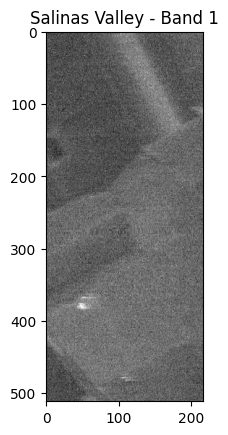

In [9]:
import matplotlib.pyplot as plt

# Display the first spectral band (band 1) of Pavia University
plt.imshow(salinas[:, :, 0], cmap='gray')
plt.title('Salinas Valley - Band 1')
plt.show()

In [10]:
# Load the ground truth .mat file
salinas_gt_data = sio.loadmat('Salinas_gt.mat')

# Print all the keys in the file to see available variables
print(salinas_gt_data.keys())

# The ground truth key is 'salinas_gt' (or modify if the key is different)
if 'salinas_gt' in salinas_gt_data:
    salinas_gt = salinas_gt_data['salinas_gt']
    print(f"Type of 'salinas_gt': {type(salinas_gt)}")
    print(f"Shape of 'salinas_gt': {salinas_gt.shape}")
else:
    print("Key 'salinas_gt' not found. Check the keys in the ground truth file.")

dict_keys(['__header__', '__version__', '__globals__', 'salinas_gt'])
Type of 'salinas_gt': <class 'numpy.ndarray'>
Shape of 'salinas_gt': (512, 217)


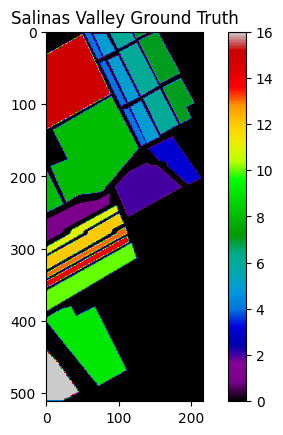

In [11]:
import matplotlib.pyplot as plt

# Display the ground truth for Salinas Valley
plt.imshow(salinas_gt, cmap='nipy_spectral')  # Use a colormap suitable for categorical data
plt.colorbar()  # Show a color bar to indicate class labels
plt.title('Salinas Valley Ground Truth')
plt.show()

## Training the Model:

In [12]:
def train_model(train_loader, val_loader, in_channels, num_classes, epochs=20, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = HyperspectralClassificationModel(in_channels=in_channels, num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.permute(0, 3, 1, 2).to(device), labels.to(device)  # [B, C, H, W]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Validation step
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.permute(0, 3, 1, 2).to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return model

## Testing the Model and calculating metrics:

In [13]:
def test_model(model, test_loader, y_test, num_classes):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    y_pred = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.permute(0, 3, 1, 2).to(device)  # [B, C, H, W]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())

    metrics = calculate_metrics(y_test, y_pred, num_classes)
    return metrics

# Main script to evaluate different window sizes
if __name__ == "__main__":
    window_sizes = [8, 9, 10, 11, 12]  # List of window sizes
    num_classes = 16  # Salinas has 16 classes
    in_channels = 204  # Salinas has 204 spectral bands
    
    for window_size in window_sizes:
        print(f"Evaluating window size: {window_size}x{window_size}")
        
        # Load data with splits for training (300), validation (300), and remaining test set
        train_loader, val_loader, test_loader, y_test = load_salinas_data_with_splits(window_size)
        
        # Train the model
        model = train_model(train_loader, val_loader, in_channels=in_channels, num_classes=num_classes, epochs=100, lr=3e-4)
        
        # Test the model and get metrics
        metrics = test_model(model, test_loader, y_test, num_classes)
        
        print(f"Metrics for window size {window_size}x{window_size}: {metrics}")

Evaluating window size: 8x8
Epoch [1/100], Train Loss: 266.7240, Val Loss: 45.2156, Val Accuracy: 0.6452
Epoch [2/100], Train Loss: 33.6104, Val Loss: 25.6168, Val Accuracy: 0.7163
Epoch [3/100], Train Loss: 21.9113, Val Loss: 33.9316, Val Accuracy: 0.5752
Epoch [4/100], Train Loss: 17.0967, Val Loss: 17.9758, Val Accuracy: 0.7375
Epoch [5/100], Train Loss: 13.1176, Val Loss: 16.0219, Val Accuracy: 0.7494
Epoch [6/100], Train Loss: 93.2356, Val Loss: 485.2438, Val Accuracy: 0.3767
Epoch [7/100], Train Loss: 196.7615, Val Loss: 96.5216, Val Accuracy: 0.6498
Epoch [8/100], Train Loss: 39.1292, Val Loss: 75.0257, Val Accuracy: 0.6756
Epoch [9/100], Train Loss: 14.0366, Val Loss: 98.3141, Val Accuracy: 0.7033
Epoch [10/100], Train Loss: 17.7046, Val Loss: 5.4964, Val Accuracy: 0.9204
Epoch [11/100], Train Loss: 8.2692, Val Loss: 8.2084, Val Accuracy: 0.8731
Epoch [12/100], Train Loss: 10.9599, Val Loss: 12.5043, Val Accuracy: 0.8779
Epoch [13/100], Train Loss: 10.3327, Val Loss: 22.9537, V